In [59]:
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import ast
from scipy.stats import variation

In [60]:
# Read in required datasets
# Congo Corpus
congo_corpus_df = pd.read_json('./data/arab_observer_congo_cleaned.json', orient='records')

congo_corpus_url = './data/arab_observer_congo_cleaned.json'
congo_corpus_df['datetime'] = pd.to_datetime(congo_corpus_df['date'], format='%Y-%B-%d', errors='coerce')
congo_corpus_dates = congo_corpus_df.date.unique().tolist()
ec =  congo_corpus_df.loc[(congo_corpus_df.datetime < '1963-01-01')]
lc = congo_corpus_df.loc[(congo_corpus_df.datetime > '1962-12-31')]


early_congo_url_tfidf = './data/processed_early_congo_tfidf.json'
tfidf_early_congo = pd.read_json(early_congo_url_tfidf, orient='records')

late_congo_url_tfidf = './data/processed_late_congo_tfidf.json'
tfidf_late_congo = pd.read_json(late_congo_url_tfidf, orient='records')

In [61]:
def len_pages(rows):
        return [len(rows) * sum(rows), len(rows), sum(rows)]
def get_tfidf_weights(tfidf, df):
    tfidf = tfidf.loc[tfidf.value != 0]

    tfidf.sort_values(by=['page_number', 'value'], ascending=[True, False], inplace=True)
    df = df.copy()
    

    z = tfidf.groupby('page_number')['value'].apply(len_pages).reset_index()
    b = pd.DataFrame(z.value.values.tolist(), index= z.index, columns=['weighted_val', 'row_count', 'sum_weights'])
    df.reset_index(drop=True, inplace=True)
    df['weighted_val'] = b.weighted_val
    df['row_count'] = b.row_count
    df['sum_weights'] = b.sum_weights
#     df[['weighted_val', 'row_count', 'sum_weights']] = pd.DataFrame(z.value.values.tolist(), index= z.index)
    df.sort_values(by=['weighted_val'], ascending=False, inplace=True)

    
    df.weighted_val = df[['weighted_val']].apply(lambda x: (x-x.min())/(x.max()-x.min())+ 0.000001)
    return df

In [62]:
early_congo = get_tfidf_weights(tfidf_early_congo, ec)
late_congo = get_tfidf_weights(tfidf_late_congo, lc)

In [63]:
early_congo = early_congo.loc[early_congo.sum_weights > early_congo.sum_weights.median()] 
late_congo = late_congo.loc[late_congo.sum_weights > late_congo.sum_weights.median()]
early_congo['classify'] = 'early_congo'
late_congo['classify'] = 'late_congo'

In [64]:
len(early_congo), len(late_congo)

(231, 197)

In [65]:
congo = pd.concat([early_congo, late_congo])
congo.to_csv('./data/congo_classifier_training_test.data.csv')

In [55]:
# Full Corpus
full_corpus_df = pd.read_json('./data/arab_observer_corpus_cleaned.json', orient='records')

full_corpus_url = './data/arab_observer_corpus_cleaned.json'
full_corpus_df['datetime'] = pd.to_datetime(full_corpus_df['date'], format='%Y-%B-%d', errors='coerce')
full_corpus_dates = full_corpus_df.date.unique().tolist()

In [66]:
early_full_corpus_df = full_corpus_df.loc[(full_corpus_df.datetime < '1963-01-01')]
late_full_corpus_df = full_corpus_df.loc[((full_corpus_df.datetime > '1962-12-31'))]
sample_early_corpus = early_full_corpus_df.groupby(['date', 'binned'])
training_early_corpus = sample_early_corpus.apply(lambda x: x.sample(frac=0.05)).reset_index(drop=True)
sample_late_corpus = late_full_corpus_df.groupby(['date', 'binned'])
training_late_corpus = sample_late_corpus.apply(lambda x: x.sample(frac=0.02)).reset_index(drop=True)
len(training_early_corpus), len(training_late_corpus)

(235, 238)

In [70]:
training_early_corpus['classify'] = 'early_time'
training_late_corpus['classify'] = 'late_time'
training = pd.concat([training_early_corpus, training_late_corpus])
training.to_csv('./data/time_classifier_training_test.data.csv')

In [ ]:
# Explore classifications

In [77]:
features_time = pd.read_csv('./data/time_classifier_features.csv')
features_congo = pd.read_csv('./data/congo_classifier_features.csv')

In [78]:
features_time.coef_0 = features_time.coef_0.abs()
features_congo.coef_0 = features_congo.coef_0.abs()

In [80]:
features_time = features_time[0:50]
features_congo = features_congo[0:50]
features = features_congo.merge(features_time, on='Unnamed: 0', how='outer')

In [88]:
feature_ec = features_congo[['coef_0', 'feature_0']]
feature_ec['type'] = 'early congo'
feature_et = features_time[['coef_0', 'feature_0']]
feature_et['type'] = 'early time'
feature_lc = features_congo[['coef_1', 'feature_1']]
feature_lc['type'] = 'late congo'
feature_lt = features_time[['coef_1', 'feature_1']]
feature_lt['type'] = 'late time'
feature_early = feature_ec.merge(feature_et, on='feature_0', how='outer')
feature_late = feature_lc.merge(feature_lt, on='feature_1', how='outer')
# feature_early_1 = feature_early.corpus_type[(terms2.type_x.isna() == False) & (terms2.type_y.isna() == True)] =  comp1
# terms2.corpus_type[(terms2.type_x.isna() == True) & (terms2.type_y.isna() == False)] = comp2

In [30]:
feature_early_both = feature_early.loc[(feature_early.type_x.isna() == False) & (feature_early.type_y.isna() == False)]
feature_late_both = feature_late.loc[(feature_late.type_x.isna() == False) & (feature_late.type_y.isna() == False)]

In [94]:
feature_early_1 = feature_early.loc[feature_early.type_x == 'early congo']
feature_early_1.type_x[feature_early_1.type_y == 'early time'] = 'both corpuses'

feature_early_2 = feature_early.loc[feature_early.type_y == 'early time']
feature_early_2.type_y[feature_early_2.type_x == 'early congo'] = 'both corpuses'


In [95]:
feature_late_1 = feature_late.loc[feature_late.type_x == 'late congo']
feature_late_1.type_x[feature_late_1.type_y == 'late time'] = 'both corpuses'
feature_late_2 = feature_late.loc[feature_late.type_y == 'late time']
feature_late_2.type_y[feature_late_2.type_x == 'late congo'] = 'both corpuses'

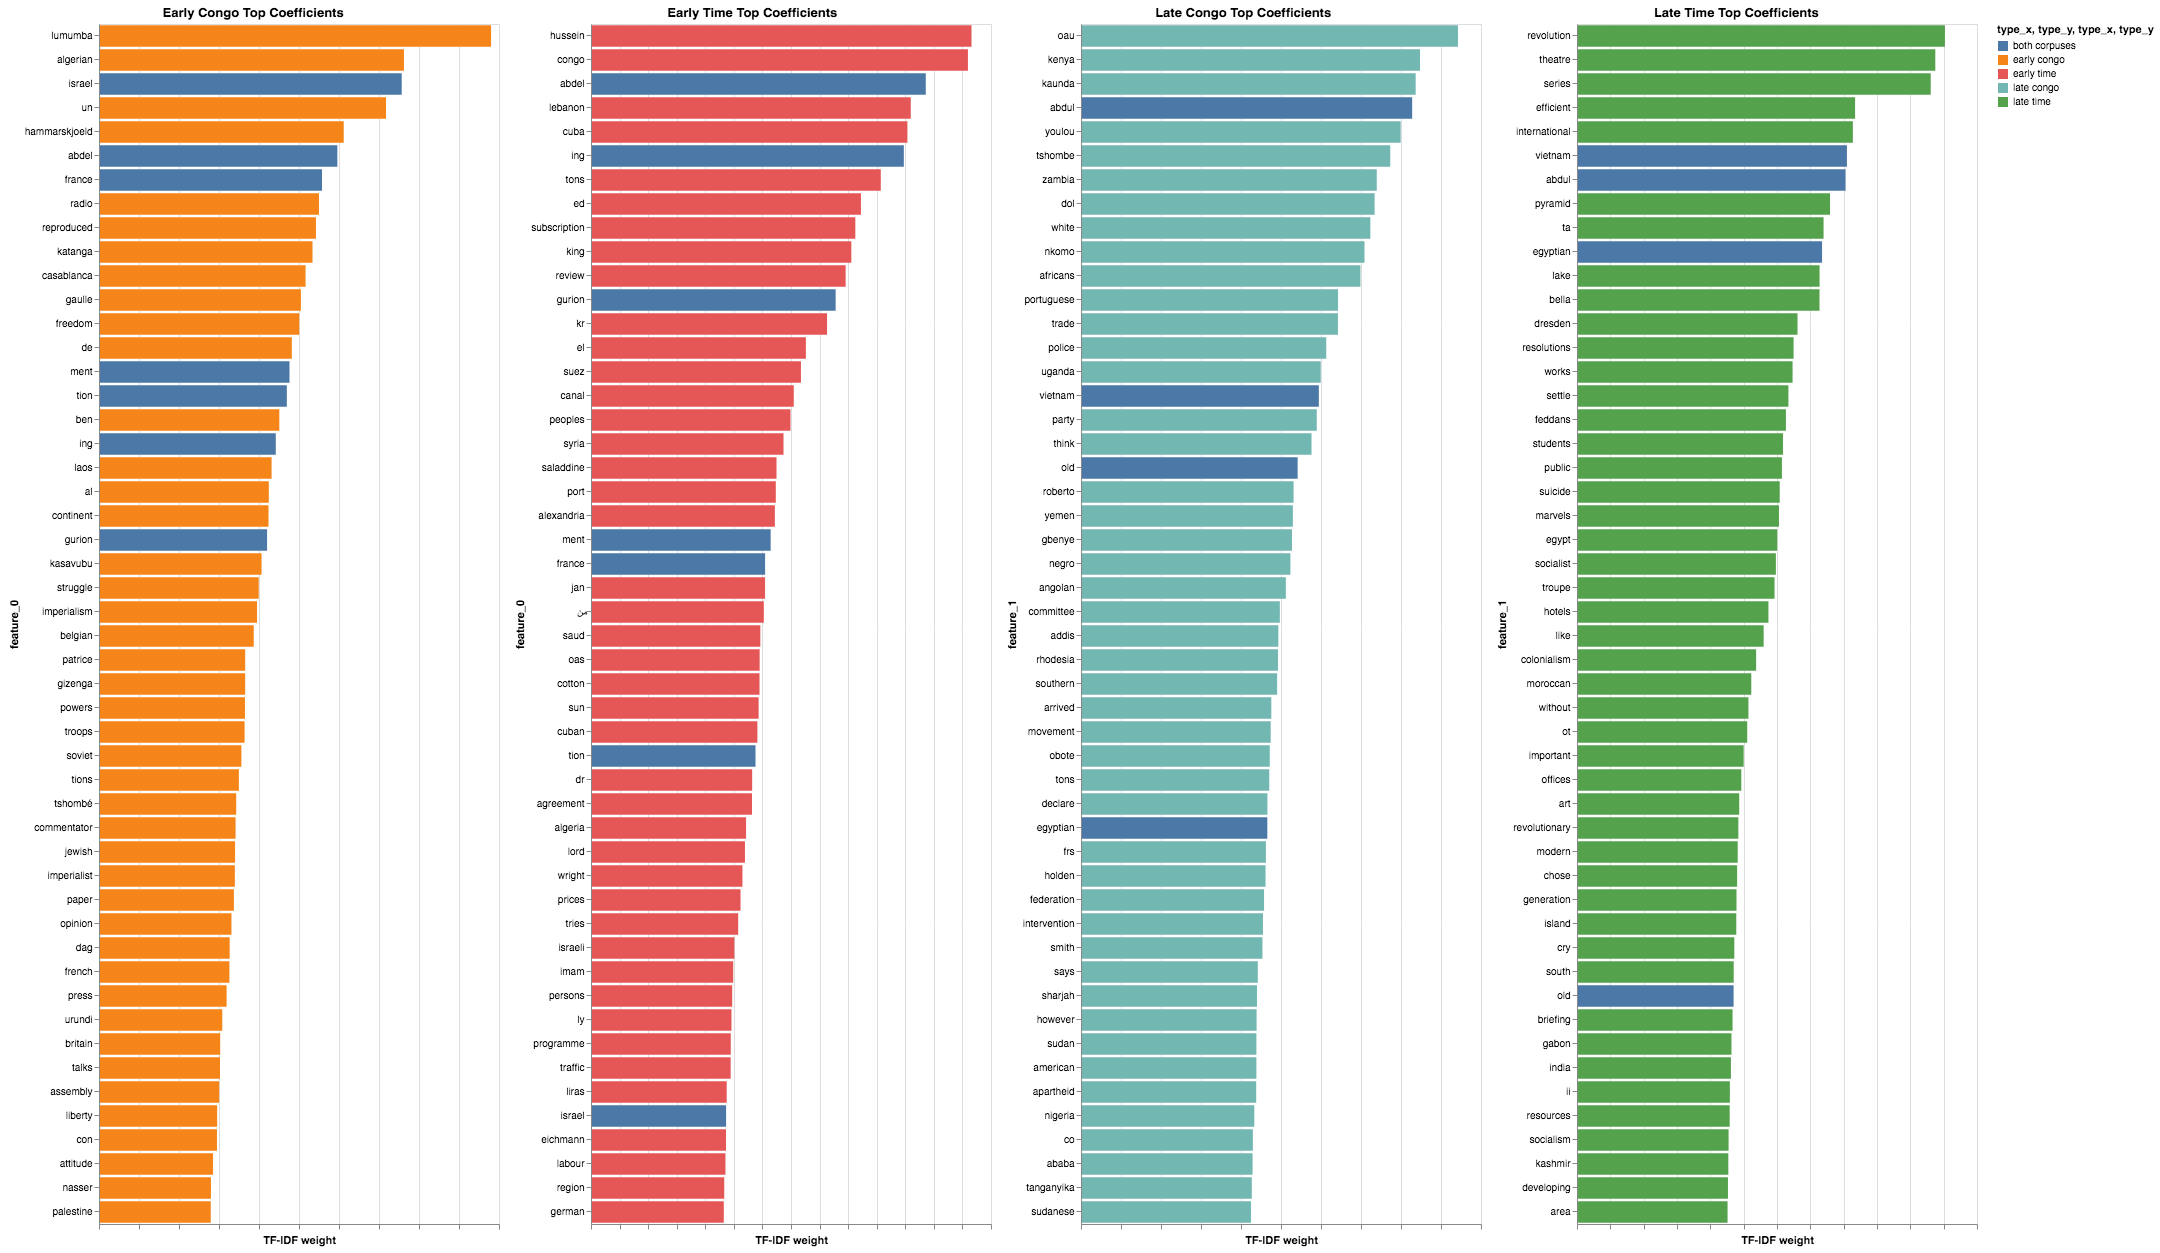

In [96]:

total_freq = alt.Chart(feature_early_1).mark_bar().encode(
    x=alt.X('coef_0_x:Q', axis=alt.Axis(title='TF-IDF weight')),
    y=alt.Y(
        'feature_0:N',
         sort=alt.EncodingSortField(
            field="coef_0_x",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        )
    ),
    color='type_x:N'

).properties(title='Early Congo Top Coefficients', height=1200)


congo_freq = alt.Chart(feature_early_2).mark_bar().encode(
    x=alt.X('coef_0_y:Q', axis=alt.Axis(title='TF-IDF weight')),
    y=alt.Y(
        'feature_0:N',
         sort=alt.EncodingSortField(
            field="coef_0_y",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        )
    ),
    color='type_y:N'

).properties(title='Early Time Top Coefficients', height=1200)


total_freq2 = alt.Chart(feature_late_1).mark_bar().encode(
    x=alt.X('coef_1_x:Q', axis=alt.Axis(title='TF-IDF weight')),
    y=alt.Y(
        'feature_1:N',
         sort=alt.EncodingSortField(
            field="coef_1_x",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        )
    ),
    color='type_x:N'

).properties(title='Late Congo Top Coefficients', height=1200)


congo_freq2 = alt.Chart(feature_late_2).mark_bar().encode(
    x=alt.X('coef_1_y:Q', axis=alt.Axis(title='TF-IDF weight')),
    y=alt.Y(
        'feature_1:N',
         sort=alt.EncodingSortField(
            field="coef_1_y",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
        )
    ),
    color='type_y:N'

).properties(title='Late Time Top Coefficients', height=1200)

alt.themes.enable('opaque')
alt.hconcat(total_freq | congo_freq| total_freq2 | congo_freq2 ).configure_axisX(labelAngle=0, labels=False)



In [143]:
congo_classified = pd.read_csv('./data/congo_classifier_classified_corpus.csv')
print(len(congo_classified))
time_classified = pd.read_csv('./data/time_classifier_classified_corpus.csv')
print(len(time_classified))
congo_classified.prediction[congo_classified.prediction == 0] = 'early_congo'
congo_classified.prediction[congo_classified.prediction == 1] = 'late_congo'

time_classified.prediction[time_classified.prediction == 0] = 'early_time'
time_classified.prediction[time_classified.prediction == 1] = 'late_time'

congo_classified['datetime'] = pd.to_datetime(congo_classified['string_date'], format='%Y-%B-%d', errors='coerce')
congo_classified['date_bin'] = congo_classified.date.astype(str) +'_'+congo_classified.binned.astype(str)
congo_classified['date_bin_page'] = congo_classified.date.astype(str) +'_'+congo_classified.binned.astype(str) +'_'+congo_classified.page_number.astype(str)

time_classified['datetime'] = pd.to_datetime(time_classified['string_date'], format='%Y-%B-%d', errors='coerce')
time_classified['date_bin'] = time_classified.date.astype(str) +'_'+time_classified.binned.astype(str)
time_classified['date_bin_page'] = time_classified.date.astype(str) +'_'+time_classified.binned.astype(str)+'_'+time_classified.page_number.astype(str)

13083
13083


In [158]:
congo_classified.sort_values(by=['datetime', 'binned', 'page_number'], inplace=True)
congo_dates = congo_classified.date.unique().tolist()
time_classified.sort_values(by=['datetime', 'binned', 'page_number'], inplace=True)
time_dates = time_classified.date.unique().tolist()
congo_classified['abs_change_0'] = 0.5 - congo_classified.prediction_proba_0

In [159]:
congo_classified_url = './data/congo_classifier_classified_corpus.json'
congo_classified.to_json(congo_classified_url, orient='records')

time_classified_url = './data/time_classifier_classified_corpus.json'
time_classified.to_json(time_classified_url, orient='records')

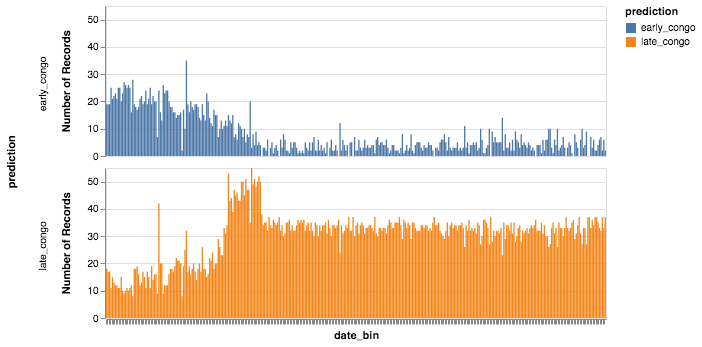

In [136]:
alt.Chart(congo_classified_url).mark_bar().encode(
    x='date_bin:N',
    y='count():Q',
    color='prediction:N',
    row='prediction:N'
).properties(
    height=150,
    width=500
).configure_axisX(labels=False)


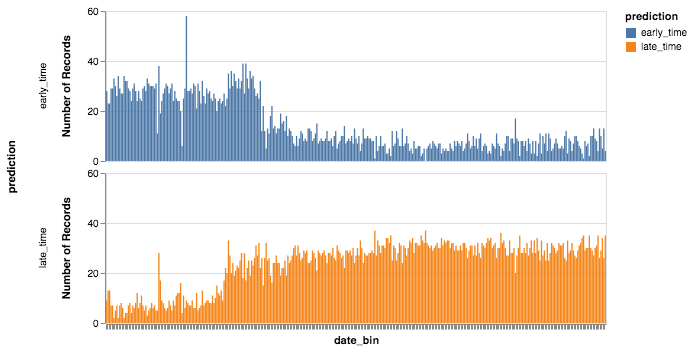

In [137]:
alt.Chart(time_classified_url).mark_bar().encode(
    x='date_bin:N',
    y='count():Q',
    color='prediction:N',
    row='prediction:N'
).properties(
    height=150,
    width=500
).configure_axisX(labels=False)


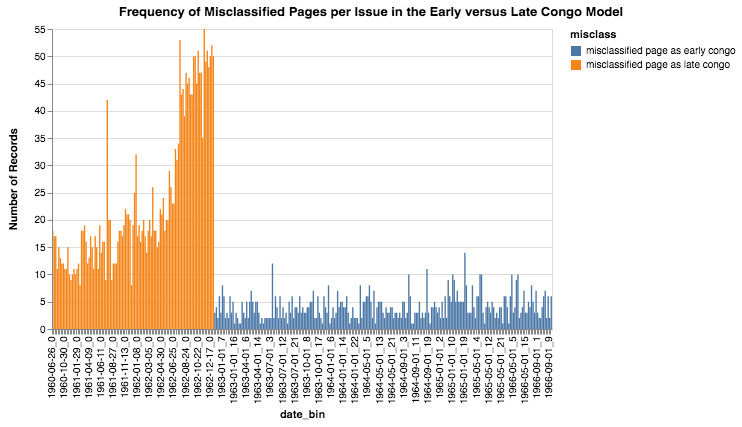

In [157]:
congo_classified['misclass'] = 'accurate'
congo_classified.misclass[(congo_classified.date > '1962-12-32') & (congo_classified.prediction == 'early_congo')] = 'misclassified page as early congo'
congo_classified.misclass[(congo_classified.date < '1963-01-01') & (congo_classified.prediction == 'late_congo')] = 'misclassified page as late congo'
alt.themes.enable('opaque')
missed = congo_classified.loc[congo_classified.misclass != 'accurate']
missed.sort_values(by=['date', 'binned', 'page_number'], inplace=True)
order_dates = missed.date_bin.unique().tolist()

missed_url = './data/missed_congo_classified.json'
missed.to_json(missed_url, orient='records')
alt.Chart(missed_url).mark_bar().encode(
    x=alt.X('date_bin:O', sort=order_dates),
    y='count()',
    color='misclass:N'
).properties(
    width=500,
    title='Frequency of Misclassified Pages per Issue in the Early versus Late Congo Model'
)

In [165]:
congo_classified.abs_change_0 = congo_classified.abs_change_0.abs()

Text(0.5, 0, '')

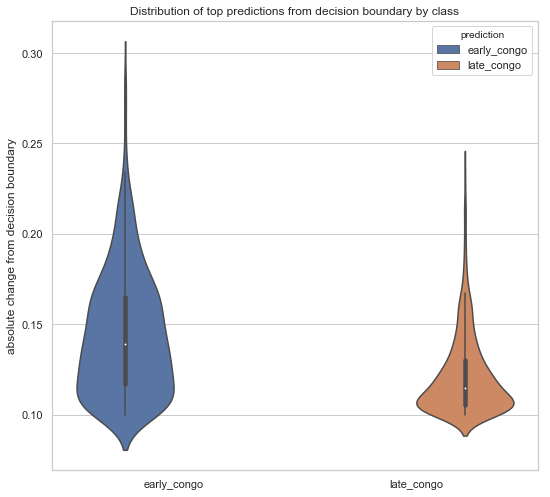

In [166]:

sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(8.7,8.27)}, style="whitegrid")
ax = sns.violinplot(x="prediction", y="abs_change_0", hue="prediction", data=congo_classified.loc[congo_classified.abs_change_0 > 0.1])
# ax.set_size_inches(15,15)
# axes = g.axes.flatten()
ax.set_title('Distribution of top predictions from decision boundary by class')
ax.set_ylabel('absolute change from decision boundary')
ax.set_xlabel('')
# ax.figure.savefig('decision_boundary.png')